In [12]:
# Generelle moduler og funksjonsbeskrivelser brukt i forelesningen
from numpy import sin, cos, pi, exp
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [8.00, 4.5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.xmargin"] = 0.0

def displayFrequencyResponse(b, a=[1], num=None, mag='log', new_figure=True, **kwargs):
    w, Hw = sig.freqz(b, a)
    H_amp = np.abs(Hw)
    H_phase = np.unwrap(np.angle(Hw, deg=True), period=360)
    if new_figure==True:
        if num is not None:
            plt.close(num)
        fig, [ax1, ax2] = plt.subplots(num=num, nrows=2)
    else :
        fig = plt.figure(num=num)
        ax1 = fig.axes[0]
        ax2 = fig.axes[1]
    
    if mag.lower()=='log':
        ax1.plot(w, 20*np.log10(H_amp), **kwargs)
        ax1.set_ylabel(r'$\left| H\left(\hat{\omega}\right)\right|$ (dB)')
    else:
        ax1.plot(w, H_amp, **kwargs)
        ax1.set_ylabel(r'$\left| H\left(\hat{\omega}\right)\right|$')

    ax1.set_xticks(np.linspace(0, 1, 6)*pi, [str(round(i,2))+r'$\pi$' for i in np.linspace(0, 1, 6)])
    #ax1.set_xlabel(r'Normalized Angular Frequency $\hat{\omega}$')

    ax1.set_xlim([0, pi])
    ax1.set_title(r'Frequency Response $H\left(\hat{\omega}\right)$')

    phaseResp, = ax2.plot(w, H_phase, **kwargs)

    ax2.set_xticks(np.linspace(0, 1, 6)*pi, [str(round(i,2))+r'$\pi$' for i in np.linspace(0, 1, 6)])
    ax2.set_xlabel(r'Normalized Angular Frequency $\hat{\omega}$')
    ax2.set_ylabel(r'$\angle H(\hat{\omega})$')
    
    yticks = ax2.get_yticks()
    ax2.set_yticks(yticks)
    ax2.set_yticklabels([f'${x}^\\circ$' for x in yticks])

    if "label" in kwargs.keys():
        ax2.legend()
        ax1.legend()
    fig.tight_layout(pad=0.1, w_pad=1.0, h_pad=1.0)

%matplotlib ipympl

<img src="figures/NTNU_logo_vertical.svg" align="left" style="width: 30%">
<br clear="all" />
<br></br>

# Optimal FIR Filter Design

* **Emne AIS2201 - Digital Signal Processing**
* **Week 44, 2025**
* **Related Reading Materials:**
    * Chapter 5.6 in the book Understanding Digital Signal Processing
* **Lecturer: Kai Erik Hoff**

# Topics

* Formulation of FIR Filter design as an optimization problem
* Introducing the Parks McClellan Exchange algorithm for FIR Filter Design
    * aka. Remez Exchange Algorithm or Equiripple filters
* Narrowband Differentiators

### Learning goals

* Knowing how to make full use of the range of input parameters avialable in the Remez Exchange design method

## Recap: Important terms in filter design


<div style="width: 100%;">
<img src="figures/Fig1_FilterParams.png" style="width: 50%; float: left" />
    <div style="width: 40%; float: right; margin-left: -10%">
    <ul>
        <br>
        <li><b>Minimum Stopband Attenuation:</b><br>the distance between the passband and the <i>hightest point</i> in the stopband.</li>
        <li><b>Stopband:</b><br>The frequency band where filter attenuation is greater than the minimum stopband attenuation. Bounded by $\hat{\omega}_{\text{stop}}$</li>
        <li><b>Maximum Passband Ripple:</b><br>Peak permissable fluctuations within the passband.</li>
        <li><b>Passband:</b><br>frequency band where filter gain is within the limits set by max passband ripple. Bounded by $\hat{\omega}_{\text{pass}}$</li>
        <li><b>Transition width ($\text{TW}$):</b><br> Width of frequency band between edge of passband and edge of stopband.</li>
    </ul> 
    </div>
</div> 


# Key points in filter design:


* **Symmetrical Impulse response: $h[n] = h[M-n-1]$**
    * Ensures ***linear phase response*** in passband: $\angle H(\hat{\omega}) = -\frac{M-1}{2}\cdot \hat{\omega}$
    * All frequency components time-shifted equally $\rightarrow$ signal shape is preserved

* Odd numbered filter lenght $M$ is often desirable:
    * The ***group delay*** $D(\hat{\omega}) = - \frac{d \angle H(\hat{\omega})}{d\hat{\omega}}=\frac{M-1}{2}$ is an integer.
    * All frequency components being delayed by an integer number of samples makes it easy to align differently filtered signals with $0$ relative phase difference.

## Example:
* Find a *general expression* frequency response $H(\hat{\omega})$ for a $M=5$-tap FIR filter with symmetrical impulse response $h[n] = h[4-n]$, where the specific values of each sample $h[n]$ is not determined:

* Can we infer a further generalization which holds for *any* odd-length filter?

# FIR filter general form of frequency response

$$\large H(\hat{\omega}) = \left( h\left[D \right] + 2\sum_{n=1}^{D} h\left[n + D\right] \cdot \cos \left(n \cdot \hat{\omega} \right) \right) \cdot e^{-j\hat{\omega} \cdot D}, \ \ \ D = \frac{M-1}{2}$$

* Not dissimilar to fourier series reconstruction, except we're now constructing a continuous *frequency-domain* function from discrete *time-domain* samples $h[n]$


* For any given frequency $\hat{\omega}$, the response contribution from each sample in the impulse response is *linearly independent*. 

# Optimal FIR filter design

* Define an error function:

$$ E\left(\vec{h}\right) = \max\left( H_{\text{ideal}}(\hat{\omega}) - H(\hat{\omega})\right)^2$$

* Find the vector  $\vec{h} = \left[h[0], h[1], \ldots , h[M-1] \right]^T$ which minimizes the error function $E\left(\vec{h}\right)$
    * Similar to "conventional" least squares problems
    * [Remez Exchange Algorithm](https://docs.scipy.org/doc/scipy-1.8.0/html-scipyorg/reference/generated/scipy.signal.remez.html) especially designed to solve this optimization problem

* Enables designing FIR filters which meets design specifications, using a smaller number of filter taps $M$ compared to the window method.
    * Downside: computationally intensive, and may fail to find the optimal solution

# Comparing windowed FIR filters to optimal FIR filters

<img src="figures/remez_exchange.svg" style="width: 80%; margin-left: 50px" />

# Optimal filters allow for separate weighing of different bands

<img src="figures/remez_relative_weights.svg" style="width: 80%; margin-left: 50px" />

# Usage: Lowpassfilter

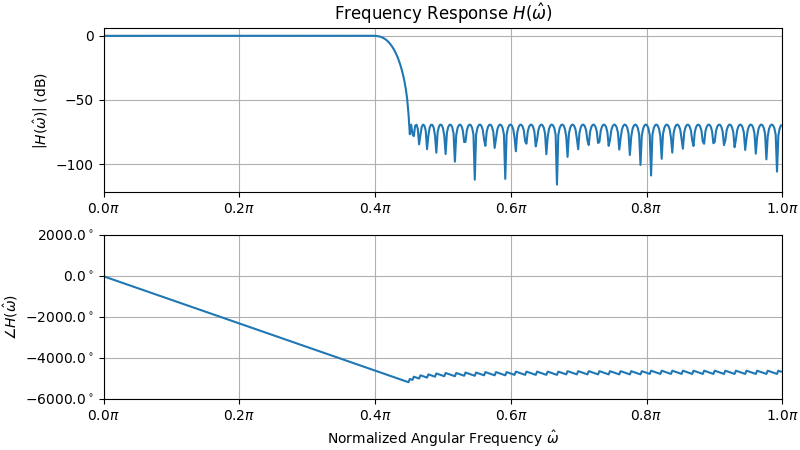

In [13]:
fs = 20_000       # Sample rate, Hz
w_pass = 4_000    # Desired cutoff frequency, Hz
w_stop = 4_500      # Width of transition from pass band to stop band, Hz
numtaps = 129      # Size of the FIR filter.

hn = sig.remez(numtaps,                                    # Lengde på impulsrespons = filterorden + 1
               [0, w_pass, w_stop, 0.5*fs],  # Alle 'kantfrekvensene' etter tur 
               [1, 0],                                     # Ønsket filtergain i de ulike båndene
               fs=fs,                                      # Samplingsfrekvens
               weight=[1, 10],                              # Relative weighing of error function in the two bands
               type='bandpass'                                           
              )

displayFrequencyResponse(b=hn)

# Usage: Bandpassfilter

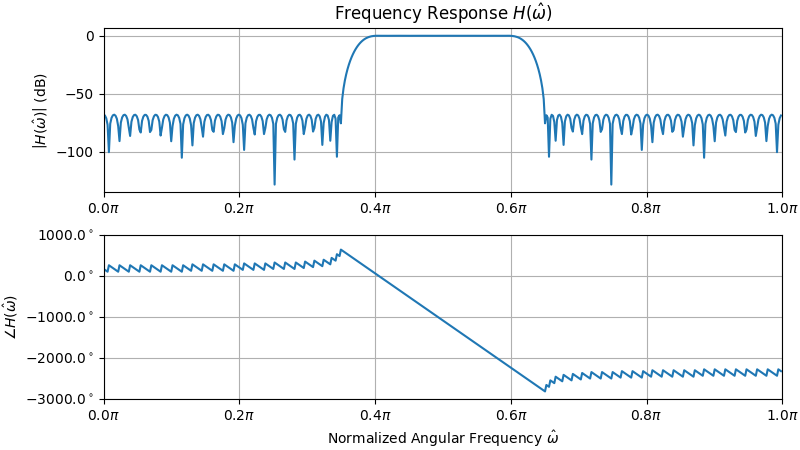

In [14]:
fs = 20_000       # Sample rate, Hz
w_lower = 4_000   # Lower passband edge frequency
w_upper = 6_000
TW = 500           # Transition Bandwidth
numtaps = 129      # Size of the FIR filter.

hn = sig.remez(numtaps,                                    # Lengde på impulsrespons = filterorden + 1
               [0, w_lower-TW, w_lower, w_upper, w_upper+TW, 0.5*fs],  # Alle 'kantfrekvensene' etter tur 
               [0, 1, 0],                                     # Ønsket filtergain i de ulike båndene
               fs=fs,                                      # Samplingsfrekvens
               weight=[10, 1, 10],                              # Relative weighing of error function in the two bands
               type='bandpass'                                           
              )

displayFrequencyResponse(b=hn)

# Alternative filter shapes: *Differentiators*

* The Remez Exchange algorithm can potentially be tailored to fit any useful shape in the frequency domain.

<div style="width: 100%;">
    <img src="figures/bandlimited_differentiator.svg" style="width: 55%; float: right" />
    <div style="width: 35%; float: left">
    <br>
    <ul>
        <li>One highly useful filter type: <i>bandlimited differentiators</i>.</li>
    </ul>
    <p>$$H_{\text{ideal}}(\hat{\omega}) = \begin{cases} j\hat{\omega}, & |\hat{\omega}| \leq \hat{\omega}_c \\ 0, & |\hat{\omega}| > \hat{\omega}_c \end{cases}$$</p>
    </div>
</div> 


* Differentiates a signal which enhances abrupt changes, while at the same time suppressing high-frequency noise.

# Usage: bandlimited differentiator

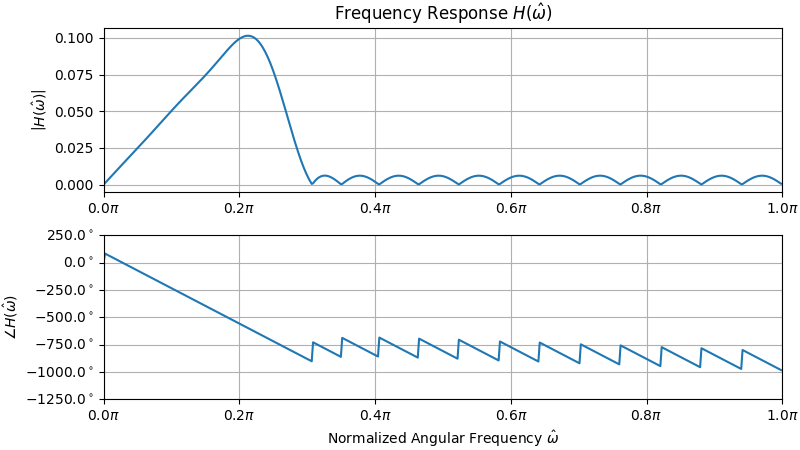

In [17]:
fs = 10_000       # Sample rate, Hz
w_pass = 1000     # Desired cutoff frequency, Hz
w_stop = 1500     # Width of transition from pass band to stop band, Hz
numtaps = 37      # Size of the FIR filter.

hn_diff = sig.remez(numtaps,                                    # Lengde på impulsrespons = filterorden + 1
               [0, w_pass, w_stop, 0.5*fs],  # Alle 'kantfrekvensene' etter tur 
               [1, 0],                                     # Ønsket filtergain i de ulike båndene
               fs=fs,                                      # Samplingsfrekvens
               weight=[1, 1],                             # Vi "bryr oss" 10 ganger mer om rippel i passbånd 
                                                           # enn demping i stoppbånd
               type='differentiator'
              )

displayFrequencyResponse(b=hn_diff, mag='lin')

# Differentiator filter properties

Text(0.5, 0, 'Sample number $n$')

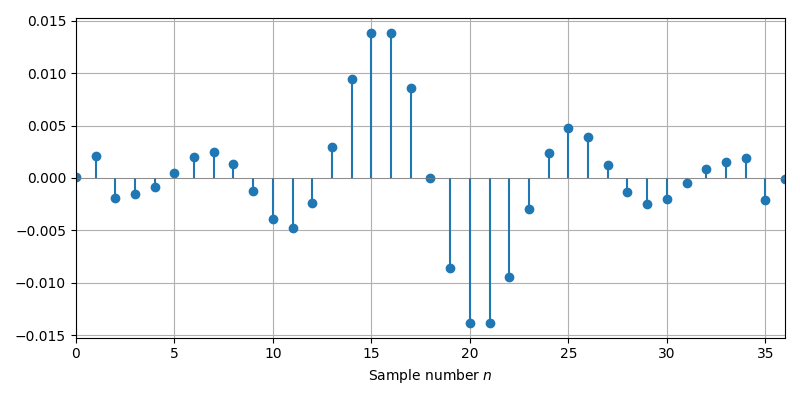

In [21]:
plt.close(5); plt.figure(5, figsize=(8,4))
plt.stem(hn_diff, basefmt='grey').baseline.set_linewidth(0.5)
plt.xlabel("Sample number $n$")

* Impulse response has ***odd symmetry***: $h[n] = -h[M-1-n]$

* Output is delayed by $\frac{M-1}{2}$ samples ($y[n]$ is the bandlimited derivative for input sample sample $x\left[n - \small{\frac{M-1}{2}}\right]$). 

* Phase response: $\angle H(\hat{\omega}) = \frac{\pi}{2} - \frac{M-1}{2}\cdot \hat{\omega}$
    * Note how the phase response is offset by $\frac{\pi}{2} \text{rad} = 90^\circ$ relative to "regular" lowpass filters etc.

# Questions?